In [1]:
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

from bs4 import BeautifulSoup as Soup

from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


In [2]:
from dotenv import load_dotenv
import os

# Load the environment variables from the .env file
load_dotenv()

# Access environment variables
api_key = os.getenv("OPENAI_KEY")

In [3]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36",
    "Accept-Language": "en-GB,en;q=0.5",
    "Referer": "https://google.com",
    "DNT": "1"
}

In [4]:
url = "https://parkhoteltokyo.com"
url = "https://www.nokuhotels.com/kyoto/"
url = "https://www.millenniumhotels.com/en/london/the-baileys-hotel-london/"

In [9]:
loader = RecursiveUrlLoader(
    url=url, max_depth=1, headers=headers, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

In [10]:
print(len(docs))

1


In [11]:
docs

[Document(page_content="\n\n\n\n\n\n\nThe Bailey's Hotel London Kensington | South Kensington Hotel UK\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nThe Baileys Hotel London\nSet in a stunning Victorian-era townhouse, The Bailey's Hotel London Kensington combines old-world charm with the flair of fashionable South Kensington. \nhttps://www.millenniumhotels.com/en/london/the-baileys-hotel-london/\nPhone: +44 2073 736000\nCheck-in:15:003pm\nCheck -out:\nRoom rates: GBP 162.00-598.80\n\n140 Gloucester Road London, United Kingdom SW7 4QH\nSW7 4QH\nLondon\nUK\n\n4.5out of\n 5 stars-\n2140votes\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\r\nHotel                                \n\n\n\n\n\r\nRooms                                \n\n\n\n\n\r\nOffers                                \n\n\n\n\n\r\nDining                                \n\n\n\n\n\r\nContact Us                                \n\n\n\n\n\r\nMeetin

In [8]:
# Define prompt
prompt_template = """Write a concise summary of the following:
"{text}"
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

# Define LLM chain
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k")
llm_chain = LLMChain(llm=llm, prompt=prompt)

# Define StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="text")

print(stuff_chain.run(docs[3:4]))

/home/stuart/.pyenv/versions/3.10.6/envs/content_app/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


The Bailey's Hotel in London offers four restaurants, including an Asian cuisine bar and a Singaporean restaurant. They also offer afternoon tea and Indian cuisine. The hotel provides luxury accommodations and amenities, and they have various programs and partnerships for guests. The website also includes information about the hotel's corporate responsibility and career opportunities.


In [9]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
document_token_lengths = [len(encoding.encode(doc.page_content)) for doc in docs]

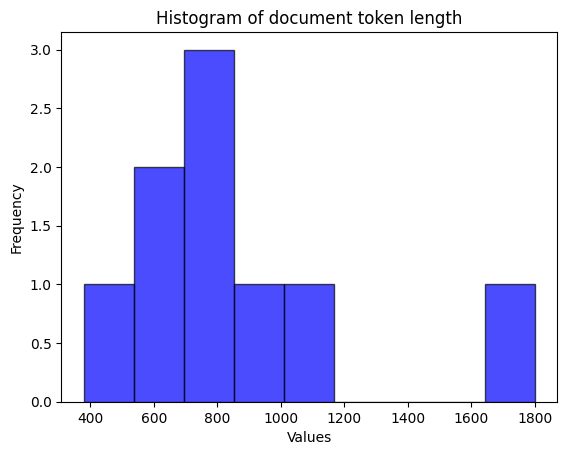

In [10]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(document_token_lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of document token length')

# Show the plot
plt.show()


In [11]:
# Count occurrences of values over 3000
count_over_2500 = sum(x > 2500 for x in document_token_lengths)
count_over_2500

0

In [12]:
for doc in docs:
    if len(encoding.encode(doc.page_content)) > 2500:
        print(doc.metadata['source'], len(encoding.encode(doc.page_content)))

In [13]:
import re
new_docs = []
for doc in docs:
    if len(encoding.encode(doc.page_content)) < 2500:
        new_docs.append(doc)

In [14]:
# Remove 2 or more consecutive \n with a single \n in each document
for doc in new_docs:
    doc.page_content = re.sub(r'\n{2,}', '\n', doc.page_content)

In [15]:
# Remove 2 or more consecutive \t with a single \t in each document
for doc in new_docs:
    doc.page_content = re.sub(r'\t{2,}', '\t', doc.page_content)

In [16]:
new_document_token_lengths = [len(encoding.encode(doc.page_content)) for doc in new_docs]

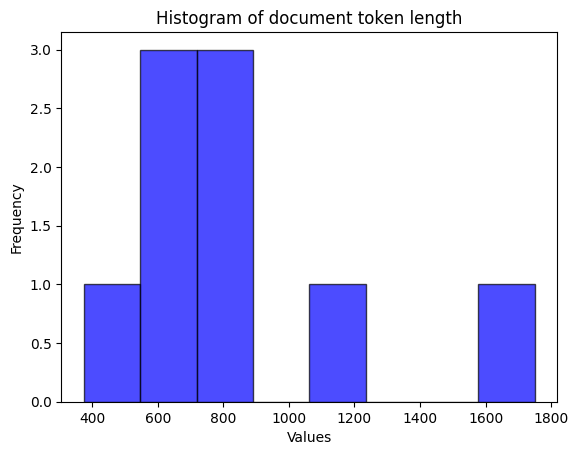

In [17]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(new_document_token_lengths, bins='auto', alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of document token length')

# Show the plot
plt.show()

In [24]:
# Summarisarion

In [18]:
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
from langchain.text_splitter import CharacterTextSplitter

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
# llm = ChatOpenAI(temperature=0, model_name="gpt-4")

# Map
map_template = """The following is a set of documents from a hotel website
{docs}
Based on this list of docs, summaries the docs based on the following categories: Hotel style, Rooms & Suites, Location, Restaurants and facilities.
If the document does not contain inforamtion about one or more of of the categories do not make the information up.
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

In [19]:
# Reduce
reduce_template = """The following is set of summaries of each webpage from a hotels website:
{docs}
Take these and distill it into a final summary including each of the main themes: Hotel style, Rooms & Suites, Location, Restaurants and facilities. 
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [20]:
# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

In [21]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

In [22]:
summarized_text_2 = map_reduce_chain.run(new_docs)
print(summarized_text_2)

The Bailey's Hotel London Kensington offers distinctive luxury and premium accommodations in a stunning Victorian-era townhouse in South Kensington. The hotel provides a range of room options, including family rooms and suites, decorated with British craftsmanship and modern amenities. Conveniently located near popular attractions, the hotel features dining options such as Bailey's Bar and The Bugis Singapore Restaurant. Additional facilities include a concierge, Wi-Fi, meetings and events spaces, a gym, and room service, providing guests with a comfortable and upscale lifestyle experience.


In [23]:
# include content guidelines

In [34]:
# Open the file in read mode ('r')
with open("Writing guidelines.txt", 'r') as file:
    # Read the content of the file
    file_content = file.read()

In [35]:
# Map
map_template = """The following is a set of documents from a hotel website
{docs}
Based on this list of docs, summaries the docs based on the following guidelines:

"""
map_template = map_template + file_content

map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

In [36]:
# Reduce
reduce_template = """The following is set of summaries of each webpage from a hotels website:
{docs}
Take these and distill it into a set of paragraphs using the following guidelines. One paragraph per point:

"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [37]:
final_reduce_template = reduce_template + file_content
reduce_prompt = PromptTemplate.from_template(final_reduce_template)

In [38]:
# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

In [39]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

In [40]:
summarized_text_3 = map_reduce_chain.run(new_docs)


In [41]:
print(summarized_text_3)

Hotel Name: The Bailey's Hotel London Kensington

Short Introduction:
Experience a luxurious stay at The Bailey's Hotel London Kensington, a charming 4-star hotel in the heart of fashionable South Kensington. With a fusion of British and Asian heritage, this Victorian-era townhouse offers stylish boutique rooms, modern amenities, and exceptional dining options.

Main Hotel Introduction:
The Bailey's Hotel London Kensington exudes charm and sophistication, blending Victorian grandeur with modern amenities. The hotel offers a stylish and welcoming atmosphere for guests to relax and unwind, with elegant decor and attentive service creating a memorable experience.

Location:
Located in South Kensington, The Bailey's Hotel London Kensington is within walking distance to popular attractions and shopping areas. Guests can easily explore the vibrant neighborhood and enjoy the convenience of the hotel's prime location.

Room Intro:
The rooms at The Bailey's Hotel London Kensington are elegantly

In [43]:
# sumarised audley guidelines

In [56]:
# Map
map_template = """
You are a content writer for a tour operator who is writing a hotel summary to go on our website.
The following is a set of documents from the hotel website
{docs}
Based on this list of docs, summaries the docs based on the following categories: 
- Sentence on location (lakefront, mountain views, centre of town, close to attractions?)
- Comment on style of property (small B&B, large international hotel, rustic,modern?)
- Details of facilities (room types, restaurant, gym, spa etc?)
- Anything else to note?
Not every docment will contain the information we require, it such a case do not return a summary.
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

In [57]:
# Reduce
reduce_template = """
You are a content writer for a tour operator who is writing a hotel summary to go on our website.
The following is set of summaries of each webpage from a hotels website:
{docs}
Take these and distill it into a final summary including each of the main themes:
- Sentence on location (lakefront, mountain views, centre of town, close to attractions?)
- Comment on style of property (small B&B, large international hotel, rustic,modern?)
- Details of facilities (room types, restaurant, gym, spa etc?)
- Anything else to note? 
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [58]:
# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

In [59]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

In [60]:
summarized_text_4 = map_reduce_chain.run(new_docs)
print(summarized_text_4)

The Bailey's Hotel London Kensington is ideally located in the heart of South Kensington, offering easy access to popular attractions such as the Natural History Museum and Royal Albert Hall. This luxury hotel boasts a unique blend of British and Asian heritage, providing a premium lifestyle experience for guests. The property features a variety of stylish boutique rooms, including luxury family rooms, studio suites, and signature suites. Guests can indulge in authentic Singaporean, Indian, and British cuisine at the hotel's four restaurants, including the Bugis Singapore Restaurant and Bombay Brasserie. Additional facilities include a gym, multilingual staff, room service, and meetings and events facilities. The hotel also offers a refined afternoon tea experience and a frequent flyer program for added benefits. With its distinctive luxury and premium services, The Bailey's Hotel aims to provide a welcoming atmosphere for guests seeking a comfortable and memorable stay in London.
